# Data Preprocessing function

In [1]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
scaler = StandardScaler()

from sklearn.preprocessing import LabelEncoder

# The label encoder for the target
le = LabelEncoder()

# Hyperparameter tuning

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

def tuning(X,y):
    clfs = {'lr': LogisticRegression(random_state=0)}
    pipe_clfs = {}

    for name, clf in clfs.items():
        pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

    param_grids = {}
    C_range = [10 ** i for i in range(-4, 5)]

    param_grid = [{'clf__multi_class': ['ovr'], 
                   'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                   'clf__C': C_range},
                  {'clf__multi_class': ['multinomial'],
                   'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
                   'clf__C': C_range}]

    param_grids['lr'] = param_grid

    # The list of [best_score_, best_params_, best_estimator_]
    best_score_param_estimators = []

    # For each classifier
    for name in pipe_clfs.keys():
        # GridSearchCV
        gs = GridSearchCV(estimator=pipe_clfs[name],
                          param_grid=param_grids[name],
                          scoring='accuracy',
                          n_jobs=-1,
                          cv=StratifiedKFold(n_splits=10,
                                            shuffle=True,
                                            random_state=0))
        # Fit the pipeline
        gs = gs.fit(X, y)
        print(gs.best_params_, gs.best_estimator_)

# Plot lr distribution

In [3]:
import numpy as np

def get_distribution(clf, X, y, feature, class_):
    """
    Calculate the probability distribution of a class based on a feature
    :param clf: the logistic regression classifier
    :param X: the feature vector
    :param y: the target vector
    :param feature: a feature
    :param class_: a class label of the target
    :return: the probability distribution, which is a dictionary 
             where the key is the value of the feature and value the probability:
             distribution = {val_1: proba_1, val_2: proba_2, ..., val_n: proba_n}
             
    """
    
    # Get the column number of the feature
    col = features.index(feature)
    
    # Get the encoded number of the class_
    if isinstance(class_,int):
        num = class_
    else:
        num = le.transform([class_])
    
    # Get X_sparse
    # Here, all the columns are zeros except for column col, where X_sparse[:, col] = X[:, col]
    X_sparse = np.zeros((X.shape[0], X.shape[1]))
    X_sparse[:, col] = X[:, col]
    
    # Get the unique value and the corresponding index in column col
    vals, idxs = np.unique(X_sparse[:, col], return_index=True)
    
    # Get the distribution
    distribution = {}
    # For each unique index
    for idx in idxs:
        # Get the corresponding value
        val = X_sparse[idx, col]
        
        # Get the probability of each class
        probas = clf.predict_proba(X_sparse[idx, :].reshape(1, -1)).ravel()

        # Get the probability of the class
        proba = probas[num]
        
        distribution[val] = proba
        
    return distribution

In [4]:
import matplotlib.pyplot as plt

def plot_distribution(distribution, feature, class_):
    """
    Plot the probability distribution of a class based on the feature
    :param distribution: the probability distribution, which is a dictionary 
                         where the key is the value of the feature and value the probability:
                         distribution = {val_1: proba_1, val_2: proba_2, ..., val_n: proba_n}
    :param feature: a feature
    :param class_: a class label of the target
    """
    if feature == 'w41':
        feature = 'feature14'
    elif feature == 'w25698':
        feature = 'software'
    
    # Get the probabilities
    probas = [distribution[val] for val in sorted(distribution.keys())]
    
    # Get the dataframe
    probas_df = pd.DataFrame(probas)
    
    # Get the values
    vals = sorted(distribution.keys())
    
    # Round down to 2 decimals
    vals = [round(val, 2) for val in vals]

    # Plot the bar chart
    probas_df.plot(kind='bar', color='r', figsize=(10, 5), fontsize=30, legend=False)
    
    # If the feature has more than 20 unique values
    if feature=='Ethnicity':
        plt.xticks(range(0,7),range(1,8), fontsize=30, rotation=0)
    elif len(vals) > 5:
        n = len(vals)
        mid = n // 2
        plt.xticks([0, mid, n - 1], [vals[0], vals[mid], vals[n - 1]], fontsize=30, rotation=0)
        
    plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=30)
    plt.xlabel(feature, fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.title('LR', fontsize=30, loc='center')
    plt.tight_layout()

# parkinsons' distribution

# Load data

In [5]:
import pandas as pd

# Load the data
df = pd.read_csv('parkinsons.data', header=1)

# Specify the name of the columns
df.columns = ['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']
# Specify the name of the features
features = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)' ,'MDVP:RAP' ,'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']

df.drop('name', axis=1, inplace=True)

# Get the features
X = df[features].values
# Get the target
y = df['status'].values

# Data preprocessing

In [6]:
# Standardize the features
X = scaler.fit_transform(X)

# Hyperparameter tuning

In [7]:
tuning(X,y)

{'clf__multi_class': 'ovr', 'clf__solver': 'liblinear', 'clf__C': 10} Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])


/home/user/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Fit X and y

In [8]:
from sklearn.linear_model import LogisticRegression

# Declare the classifier
clf = LogisticRegression(multi_class='ovr', solver='liblinear', C=10, random_state=0)

# Train the classifier
clf.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Plot distributions

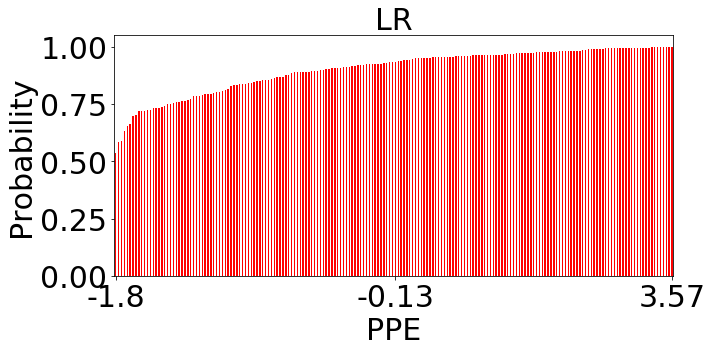

In [9]:
# Get the distribution
distribution = get_distribution(clf, X, y, 'PPE', 1)

# Plot the distribution
plot_distribution(distribution, 'PPE', 1)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/lg-parkinsons-1-PPE.png', dpi=300)
plt.show()

# Drug consuption's distributions

# Load data

In [10]:
import pandas as pd

# Load the data
df = pd.read_csv('drug_consumption.csv', header=None)

# Specify the name of the columns
df.columns = ['ID', 'Age', 'Gender', 'Education', 'Country','Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore','Cscore', 'Impulsive', 'SS', 'Alcohol', 'Amphet','Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack','Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms','Nicotine', 'Semer', 'VSA']

# Features
features = ['ID', 'Age', 'Gender', 'Education', 'Country','Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore','Cscore', 'Impulsive', 'SS']

# Get the features
X = df[features].values

# Get the target
y = df['Heroin'].values

for i in range(0,1885):
    if not y[i] == 'CL0' :
        y[i] = 'CL7'

# Data preprocessing

In [11]:
# Standardize the features
X = scaler.fit_transform(X)

# Encode the target
y = le.fit_transform(y)

# Hyperparameter tuning

In [12]:
tuning(X,y)

{'clf__multi_class': 'ovr', 'clf__solver': 'newton-cg', 'clf__C': 0.01} Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])


# Fit X and y

In [13]:
from sklearn.linear_model import LogisticRegression

# Declare the classifier
clf = LogisticRegression(multi_class='ovr', solver='newton-cg', C=0.01, random_state=0)

# Train the classifier
clf.fit(X, y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

# Plot distributions

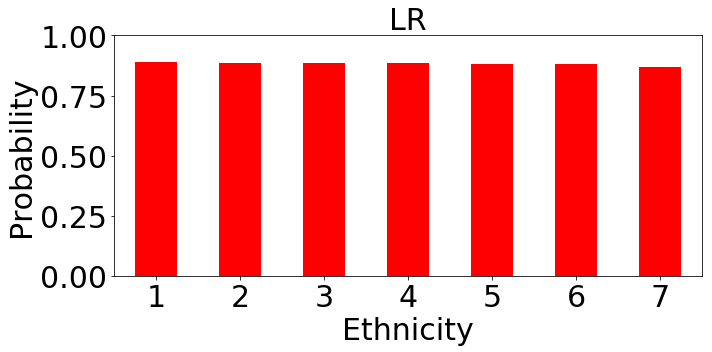

In [14]:
# Get the distribution
distribution = get_distribution(clf, X, y, "Ethnicity", 'CL0')

# Plot the distribution
plot_distribution(distribution, "Ethnicity", 'CL0')
#save the figure
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/lg-drug-cl0-Ethnicity.png', dpi=300)
plt.show()

# drosophila_enhancers' distributions

# Load data

In [15]:
# import pandas as pd

# Load the data
df = pd.read_csv('drosophila_enhancers.csv', header=1)

# Specify the name of the columns
df.columns = ['positive','H3_c12','H3_c14a','H3_c14c','H3_c8','H3K18ac_c12','H3K18ac_c14a','H3K18ac_c14c',
              'H3K18ac_c8','H3K27ac_c12','H3K27ac_c14a','H3K27ac_c14c','H3K27ac_c8','H3K27me3_c12','H3K27me3_c14a','H3K27me3_c14c','H3K36me3_c12',
              'H3K36me3_c14a','H3K36me3_c14c','H3K4me1_c12','H3K4me1_c14a','H3K4me1_c14c','H3K4me1_c8','H3K4me3_c12','H3K4me3_c14a','H3K4me3_c14c',
              'H3K4me3_c8','H3K9ac_c12','H3K9ac_c14a','H3K9ac_c14c','H3K9ac_c8','H4K5ac_c12','H4K5ac_c14a','H4K5ac_c14c','H4K5ac_c8','H4K8ac_c12',
              'H4K8ac_c14a','H4K8ac_c14c','H4K8ac_c8','input_c12','input_c14a','input_c14c','input_c8','wt_H3','wt_H3K18ac','wt_H3K4me1','wt_ZLD','bcd1',
              'bcd2','cad1','D1','da2','dl3','ftz3','gt2','h1','h2','hb1','hb2','hkb1','hkb2','hkb3','kni1','kni2','kr1','kr2','mad2','med2','prdBQ','prdFQ',
              'run1','run2','shn2','shn3','slp1','sna1','sna2','tll1','twi1','twi2','z2']

# Features
features = ['H3_c12','H3_c14a','H3_c14c','H3_c8','H3K18ac_c12','H3K18ac_c14a','H3K18ac_c14c',
              'H3K18ac_c8','H3K27ac_c12','H3K27ac_c14a','H3K27ac_c14c','H3K27ac_c8','H3K27me3_c12','H3K27me3_c14a','H3K27me3_c14c','H3K36me3_c12',
              'H3K36me3_c14a','H3K36me3_c14c','H3K4me1_c12','H3K4me1_c14a','H3K4me1_c14c','H3K4me1_c8','H3K4me3_c12','H3K4me3_c14a','H3K4me3_c14c',
              'H3K4me3_c8','H3K9ac_c12','H3K9ac_c14a','H3K9ac_c14c','H3K9ac_c8','H4K5ac_c12','H4K5ac_c14a','H4K5ac_c14c','H4K5ac_c8','H4K8ac_c12',
              'H4K8ac_c14a','H4K8ac_c14c','H4K8ac_c8','input_c12','input_c14a','input_c14c','input_c8','wt_H3','wt_H3K18ac','wt_H3K4me1','wt_ZLD','bcd1',
              'bcd2','cad1','D1','da2','dl3','ftz3','gt2','h1','h2','hb1','hb2','hkb1','hkb2','hkb3','kni1','kni2','kr1','kr2','mad2','med2','prdBQ','prdFQ',
              'run1','run2','shn2','shn3','slp1','sna1','sna2','tll1','twi1','twi2','z2']
# Get the features
X = df[features].values

# Get the target
y = df['positive'].values

# Data preprocessing

In [16]:
# Standardize the features
X = scaler.fit_transform(X)

# Hyperparameter tuning

In [17]:
tuning(X,y)

{'clf__multi_class': 'ovr', 'clf__solver': 'liblinear', 'clf__C': 0.01} Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])


# Fit X and y

In [18]:
from sklearn.linear_model import LogisticRegression

# Declare the classifier
clf = LogisticRegression(multi_class='ovr', solver='liblinear', C=0.01, random_state=0)

# Train the classifier
clf.fit(X, y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Plot distributions

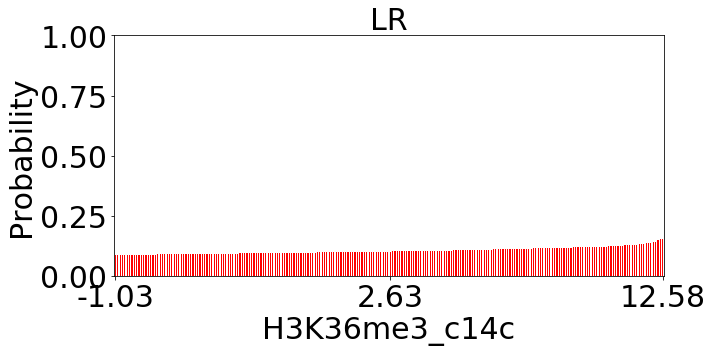

In [19]:
# Get the distribution
distribution = get_distribution(clf, X, y, 'H3K36me3_c14c', 1)

# Plot the distribution
plot_distribution(distribution, 'H3K36me3_c14c', 1)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/lg-drosophila_enhancers-1-H3K36me3_c14c.png', dpi=300)
plt.show()

# alternative_splicing' distributions

# Load data

In [20]:
import pandas as pd

# Load the data
df = pd.read_csv('alternative_splicing.csv', header=1)

# Specify the name of the columns
df.columns = ['label','MYC_body_UTA','CTCF_body_UTA','POLR2A_body_UTA','ARID3A_body_Stanford','ATF1_body_HMS','ATF3_body_HMS','BACH1_body_Stanford',
              'BDP1_body_HMS','BHLHE40_body_Stanford','BRF1_body_HMS','BRF2_body_HMS','SMARCA4_body_Stanford','CCNT2_body_HMS','CUX1_body_Stanford',
              'FOS_body_Yale','CEBPB_body_Stanford','CHD2_body_Stanford','JUN_body_Stanford','JUN_body_Yale','JUN_body_Yale.1','JUN_body_Yale.2',
              'JUN_body_Stanford.1','JUN_body_Yale.3','MYC_body_Yale','MYC_body_Yale.1','MYC_body_Stanford','MYC_body_Yale.2','MYC_body_Stanford.1',
              'MYC_body_Yale.3','RCOR1_body_Stanford','RCOR1_body_Stanford.1','E2F4_body_USC','CTCF_body_Stanford','E2F6_body_USC','ELK1_body_Stanford',
              'GATA1_body_USC','GATA1_body_Stanford','GATA2_body_USC','GTF2B_body_HMS','GTF2F1_body_Stanford','HCFC1_body_Stanford','HMGN3_body_HMS',
              'SMARCB1_body_Stanford','IRF1_body_Stanford','IRF1_body_Stanford.1','IRF1_body_Stanford.2','IRF1_body_Stanford.3','TRIM28_body_USC','JUND_body_Stanford',
              'MAFF_body_Stanford','MAFK_body_Stanford','MAX_body_Stanford','MAX_body_Yale','MXI1_body_Stanford','NFE2_body_Yale','NFYA_body_Stanford','NFYB_body_Stanford',
              'NRF1_body_Stanford','EP300_body_Stanford','EP300_body_Stanford.1','POLR2A_body_Yale','POLR2A_body_Yale.1','POLR2A_body_Stanford',
              'POLR2A_body_Yale.2','POLR2A_body_Stanford.1','POLR2A_body_Yale.3','POLR2AphosphoS2_body_Stanford','POLR2AphosphoS2_body_Stanford.1','POLR3G_body_Stanford',
              'RAD21_body_Yale','RFX5_body_Stanford','POLR3A_body_HMS','SETDB1_body_USC','SETDB1_body_USC.1','SIRT6_body_HMS','STAT1_body_Yale','SMC3_body_Stanford',
              'STAT1_body_Yale.1','STAT1_body_Stanford','STAT1_body_Stanford.1','STAT2_body_Yale','STAT2_body_Yale.1','TAL1_body_Stanford','TBL1XR1_body_Stanford','TBL1XR1_body_Stanford.1',
              'TBP_body_Stanford','GTF3C2_body_HMS','NR2C2_body_USC','UBTF_body_Stanford','UBTF_body_Stanford.1','USF2_body_Stanford','XRCC4_body_Yale','YY1',
              'ZNF143_body_Stanford','ZNF263_body_USC','ZNF274_body_USC','ZNF274_body_USC.1','ZNF384_body_Stanford','ZMIZ1_body_Stanford','eGFP.FOS_body_UChicago',
              'eGFP.GATA2_body_UChicago','eGFP.HDAC8_body_UChicago','eGFP.JUNB_body_UChicago','eGFP.JUND_body_UChicago','eGFP.NR4A1_body_UChicago','CTCF_body_UW',
              'CTCF_body_UW.1','CHD1_body_ENCODE','CTCF_body_ENCODE','EZH2_body_ENCODE','HDAC1_body_ENCODE','HDAC2_body_ENCODE','HDAC6_body_ENCODE','EP300_body_ENCODE',
              'PHF8_body_ENCODE','KDM5B_body_ENCODE','POLR2A_body_ENCODE','RBBP5_body_ENCODE','SAP30_body_ENCODE','ATF3_body_ENCODE','BCL3_body_ENCODE','CBX3_body_ENCODE',
              'CEBPB_body_ENCODE','CTCF_body_ENCODE.1','CTCFL_body_ENCODE','E2F6_body_ENCODE','EGR1_body_ENCODE','ELF1_body_ENCODE','ETS1_body_ENCODE','FOSL1_body_ENCODE',
              'GABPA_body_ENCODE','GATA2_body_ENCODE','HDAC2_body_ENCODE.1','MAX_body_ENCODE','MEF2A_body_ENCODE','NR2F2_body_ENCODE','REST_body_ENCODE','PML_body_ENCODE',
              'POLR2AphosphoS5_body_ENCODE','POLR2A_body_ENCODE.1','SPI1_body_ENCODE','RAD21_body_ENCODE','SIN3A_body_ENCODE','SIX5_body_ENCODE',
              'SP1_body_ENCODE','SP2_body_ENCODE','SRF_body_ENCODE','STAT5A_body_ENCODE','TAF1_body_ENCODE','TAF7_body_ENCODE','TEAD4_body_ENCODE','THAP1_body_ENCODE',
              'USF1_body_ENCODE','YY1_body_ENCODE','YY1_body_ENCODE.1','ZBTB33_body_ENCODE','ZBTB7A_body_ENCODE','ARID3A_body_ENCODE','ATF1_body_ENCODE','ATF3_body_ENCODE.1',
              'BACH1_body_ENCODE','BDP1_body_ENCODE','BHLHE40_body_ENCODE','BRF1_body_ENCODE','BRF2_body_ENCODE','SMARCA4_body_ENCODE','CCNT2_body_ENCODE',
              'CEBPB_body_ENCODE.1','FOS_body_ENCODE','CHD2_body_ENCODE','JUN_body_ENCODE','JUN_body_ENCODE.1','JUN_body_ENCODE.2','JUN_body_ENCODE.3',
              'JUN_body_ENCODE.4','MYC_body_ENCODE','MYC_body_ENCODE.1','MYC_body_ENCODE.2','MYC_body_ENCODE.3','MYC_body_ENCODE.4','MYC_body_ENCODE.5',
              'RCOR1_body_ENCODE','RCOR1_body_ENCODE.1','CTCF_body_ENCODE.2','E2F4_body_ENCODE','E2F6_body_ENCODE.1','ELK1_body_ENCODE','GATA1_body_ENCODE',
              'GATA2_body_ENCODE.1','GTF2B_body_ENCODE','GTF2F1_body_ENCODE','HMGN3_body_ENCODE','SMARCB1_body_ENCODE','IRF1_body_ENCODE','IRF1_body_ENCODE.1',
              'IRF1_body_ENCODE.2','IRF1_body_ENCODE.3','JUND_body_ENCODE','TRIM28_body_ENCODE','MAFF_body_ENCODE','MAFK_body_ENCODE','MAX_body_ENCODE.1',
              'MXI1_body_ENCODE','NFE2_body_ENCODE','NFYA_body_ENCODE','NFYB_body_ENCODE','NRF1_body_ENCODE','EP300_body_ENCODE.1','POLR2A_body_ENCODE.2','POLR2A_body_ENCODE.3',
              'POLR2A_body_ENCODE.4','POLR2A_body_ENCODE.5','POLR2A_body_ENCODE.6','POLR2A_body_ENCODE.7','POLR2AphosphoS2_body_ENCODE','POLR3G_body_ENCODE','RAD21_body_ENCODE.1',
              'RFX5_body_ENCODE','POLR3A_body_ENCODE','SETDB1_body_ENCODE','SETDB1_body_ENCODE.1','SIRT6_body_ENCODE','SMC3_body_ENCODE','STAT1_body_ENCODE','STAT1_body_ENCODE.1',
              'STAT1_body_ENCODE.2','STAT1_body_ENCODE.3','STAT2_body_ENCODE','STAT2_body_ENCODE.1','TAL1_body_ENCODE','TBL1XR1_body_ENCODE','TBL1XR1_body_ENCODE.1','TBP_body_ENCODE',
              'GTF3C2_body_ENCODE','NR2C2_body_ENCODE','UBTF_body_ENCODE','UBTF_body_ENCODE.1','USF2_body_ENCODE','YY1_body_ENCODE.2','ZNF143_body_ENCODE','ZNF263_body_ENCODE','ZNF274_body_ENCODE',
              'ZNF274_body_ENCODE.1','MYC_body_ENCODE.6','CTCF_body_ENCODE.3','POLR2A_body_ENCODE.8','CTCF_body_ENCODE.4','POLR2AphosphoS2_body_ENCODE.1','eGFP.FOS_body_ENCODE',
              'eGFP.GATA2_body_ENCODE','eGFP.HDAC8_body_ENCODE','eGFP.JUNB_body_ENCODE','eGFP.JUND_body_ENCODE','H3K27ac_body_Broad','H3K27me3_body_Broad','H3K36me3_body_Broad','H3K4me1_body_Broad',
              'H3K4me2_body_Broad','H3K4me3_body_Broad','H3K79me2_body_Broad','H3K9ac','H3K9me1_body_Broad','H3K9me3_body_Broad','H4K','H3K27me3_body_UW',
              'H3K27me3_body_UW.1','H3K36me3_body_UW','H3K36me3_body_UW.1','H3K4me3_body_UW','H3K4me3_body_UW.1']

# Features
features = ['MYC_body_UTA','CTCF_body_UTA','POLR2A_body_UTA','ARID3A_body_Stanford','ATF1_body_HMS','ATF3_body_HMS','BACH1_body_Stanford',
              'BDP1_body_HMS','BHLHE40_body_Stanford','BRF1_body_HMS','BRF2_body_HMS','SMARCA4_body_Stanford','CCNT2_body_HMS','CUX1_body_Stanford',
              'FOS_body_Yale','CEBPB_body_Stanford','CHD2_body_Stanford','JUN_body_Stanford','JUN_body_Yale','JUN_body_Yale.1','JUN_body_Yale.2',
              'JUN_body_Stanford.1','JUN_body_Yale.3','MYC_body_Yale','MYC_body_Yale.1','MYC_body_Stanford','MYC_body_Yale.2','MYC_body_Stanford.1',
              'MYC_body_Yale.3','RCOR1_body_Stanford','RCOR1_body_Stanford.1','E2F4_body_USC','CTCF_body_Stanford','E2F6_body_USC','ELK1_body_Stanford',
              'GATA1_body_USC','GATA1_body_Stanford','GATA2_body_USC','GTF2B_body_HMS','GTF2F1_body_Stanford','HCFC1_body_Stanford','HMGN3_body_HMS',
              'SMARCB1_body_Stanford','IRF1_body_Stanford','IRF1_body_Stanford.1','IRF1_body_Stanford.2','IRF1_body_Stanford.3','TRIM28_body_USC','JUND_body_Stanford',
              'MAFF_body_Stanford','MAFK_body_Stanford','MAX_body_Stanford','MAX_body_Yale','MXI1_body_Stanford','NFE2_body_Yale','NFYA_body_Stanford','NFYB_body_Stanford',
              'NRF1_body_Stanford','EP300_body_Stanford','EP300_body_Stanford.1','POLR2A_body_Yale','POLR2A_body_Yale.1','POLR2A_body_Stanford',
              'POLR2A_body_Yale.2','POLR2A_body_Stanford.1','POLR2A_body_Yale.3','POLR2AphosphoS2_body_Stanford','POLR2AphosphoS2_body_Stanford.1','POLR3G_body_Stanford',
              'RAD21_body_Yale','RFX5_body_Stanford','POLR3A_body_HMS','SETDB1_body_USC','SETDB1_body_USC.1','SIRT6_body_HMS','STAT1_body_Yale','SMC3_body_Stanford',
              'STAT1_body_Yale.1','STAT1_body_Stanford','STAT1_body_Stanford.1','STAT2_body_Yale','STAT2_body_Yale.1','TAL1_body_Stanford','TBL1XR1_body_Stanford','TBL1XR1_body_Stanford.1',
              'TBP_body_Stanford','GTF3C2_body_HMS','NR2C2_body_USC','UBTF_body_Stanford','UBTF_body_Stanford.1','USF2_body_Stanford','XRCC4_body_Yale','YY1',
              'ZNF143_body_Stanford','ZNF263_body_USC','ZNF274_body_USC','ZNF274_body_USC.1','ZNF384_body_Stanford','ZMIZ1_body_Stanford','eGFP.FOS_body_UChicago',
              'eGFP.GATA2_body_UChicago','eGFP.HDAC8_body_UChicago','eGFP.JUNB_body_UChicago','eGFP.JUND_body_UChicago','eGFP.NR4A1_body_UChicago','CTCF_body_UW',
              'CTCF_body_UW.1','CHD1_body_ENCODE','CTCF_body_ENCODE','EZH2_body_ENCODE','HDAC1_body_ENCODE','HDAC2_body_ENCODE','HDAC6_body_ENCODE','EP300_body_ENCODE',
              'PHF8_body_ENCODE','KDM5B_body_ENCODE','POLR2A_body_ENCODE','RBBP5_body_ENCODE','SAP30_body_ENCODE','ATF3_body_ENCODE','BCL3_body_ENCODE','CBX3_body_ENCODE',
              'CEBPB_body_ENCODE','CTCF_body_ENCODE.1','CTCFL_body_ENCODE','E2F6_body_ENCODE','EGR1_body_ENCODE','ELF1_body_ENCODE','ETS1_body_ENCODE','FOSL1_body_ENCODE',
              'GABPA_body_ENCODE','GATA2_body_ENCODE','HDAC2_body_ENCODE.1','MAX_body_ENCODE','MEF2A_body_ENCODE','NR2F2_body_ENCODE','REST_body_ENCODE','PML_body_ENCODE',
              'POLR2AphosphoS5_body_ENCODE','POLR2A_body_ENCODE.1','SPI1_body_ENCODE','RAD21_body_ENCODE','SIN3A_body_ENCODE','SIX5_body_ENCODE',
              'SP1_body_ENCODE','SP2_body_ENCODE','SRF_body_ENCODE','STAT5A_body_ENCODE','TAF1_body_ENCODE','TAF7_body_ENCODE','TEAD4_body_ENCODE','THAP1_body_ENCODE',
              'USF1_body_ENCODE','YY1_body_ENCODE','YY1_body_ENCODE.1','ZBTB33_body_ENCODE','ZBTB7A_body_ENCODE','ARID3A_body_ENCODE','ATF1_body_ENCODE','ATF3_body_ENCODE.1',
              'BACH1_body_ENCODE','BDP1_body_ENCODE','BHLHE40_body_ENCODE','BRF1_body_ENCODE','BRF2_body_ENCODE','SMARCA4_body_ENCODE','CCNT2_body_ENCODE',
              'CEBPB_body_ENCODE.1','FOS_body_ENCODE','CHD2_body_ENCODE','JUN_body_ENCODE','JUN_body_ENCODE.1','JUN_body_ENCODE.2','JUN_body_ENCODE.3',
              'JUN_body_ENCODE.4','MYC_body_ENCODE','MYC_body_ENCODE.1','MYC_body_ENCODE.2','MYC_body_ENCODE.3','MYC_body_ENCODE.4','MYC_body_ENCODE.5',
              'RCOR1_body_ENCODE','RCOR1_body_ENCODE.1','CTCF_body_ENCODE.2','E2F4_body_ENCODE','E2F6_body_ENCODE.1','ELK1_body_ENCODE','GATA1_body_ENCODE',
              'GATA2_body_ENCODE.1','GTF2B_body_ENCODE','GTF2F1_body_ENCODE','HMGN3_body_ENCODE','SMARCB1_body_ENCODE','IRF1_body_ENCODE','IRF1_body_ENCODE.1',
              'IRF1_body_ENCODE.2','IRF1_body_ENCODE.3','JUND_body_ENCODE','TRIM28_body_ENCODE','MAFF_body_ENCODE','MAFK_body_ENCODE','MAX_body_ENCODE.1',
              'MXI1_body_ENCODE','NFE2_body_ENCODE','NFYA_body_ENCODE','NFYB_body_ENCODE','NRF1_body_ENCODE','EP300_body_ENCODE.1','POLR2A_body_ENCODE.2','POLR2A_body_ENCODE.3',
              'POLR2A_body_ENCODE.4','POLR2A_body_ENCODE.5','POLR2A_body_ENCODE.6','POLR2A_body_ENCODE.7','POLR2AphosphoS2_body_ENCODE','POLR3G_body_ENCODE','RAD21_body_ENCODE.1',
              'RFX5_body_ENCODE','POLR3A_body_ENCODE','SETDB1_body_ENCODE','SETDB1_body_ENCODE.1','SIRT6_body_ENCODE','SMC3_body_ENCODE','STAT1_body_ENCODE','STAT1_body_ENCODE.1',
              'STAT1_body_ENCODE.2','STAT1_body_ENCODE.3','STAT2_body_ENCODE','STAT2_body_ENCODE.1','TAL1_body_ENCODE','TBL1XR1_body_ENCODE','TBL1XR1_body_ENCODE.1','TBP_body_ENCODE',
              'GTF3C2_body_ENCODE','NR2C2_body_ENCODE','UBTF_body_ENCODE','UBTF_body_ENCODE.1','USF2_body_ENCODE','YY1_body_ENCODE.2','ZNF143_body_ENCODE','ZNF263_body_ENCODE','ZNF274_body_ENCODE',
              'ZNF274_body_ENCODE.1','MYC_body_ENCODE.6','CTCF_body_ENCODE.3','POLR2A_body_ENCODE.8','CTCF_body_ENCODE.4','POLR2AphosphoS2_body_ENCODE.1','eGFP.FOS_body_ENCODE',
              'eGFP.GATA2_body_ENCODE','eGFP.HDAC8_body_ENCODE','eGFP.JUNB_body_ENCODE','eGFP.JUND_body_ENCODE','H3K27ac_body_Broad','H3K27me3_body_Broad','H3K36me3_body_Broad','H3K4me1_body_Broad',
              'H3K4me2_body_Broad','H3K4me3_body_Broad','H3K79me2_body_Broad','H3K9ac','H3K9me1_body_Broad','H3K9me3_body_Broad','H4K','H3K27me3_body_UW',
              'H3K27me3_body_UW.1','H3K36me3_body_UW','H3K36me3_body_UW.1','H3K4me3_body_UW','H3K4me3_body_UW.1']
# Get the features
X = df[features].values

# Get the target
y = df['label'].values

# Data preprocessing

In [21]:
# Standardize the features
X = scaler.fit_transform(X)

# Hyperparameter tuning

In [22]:
tuning(X,y)

{'clf__multi_class': 'multinomial', 'clf__solver': 'lbfgs', 'clf__C': 0.001} Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])


# Fit X and y

In [23]:
from sklearn.linear_model import LogisticRegression

# Declare the classifier
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.001, random_state=0)

# Train the classifier
clf.fit(X, y)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

# Plot distributions

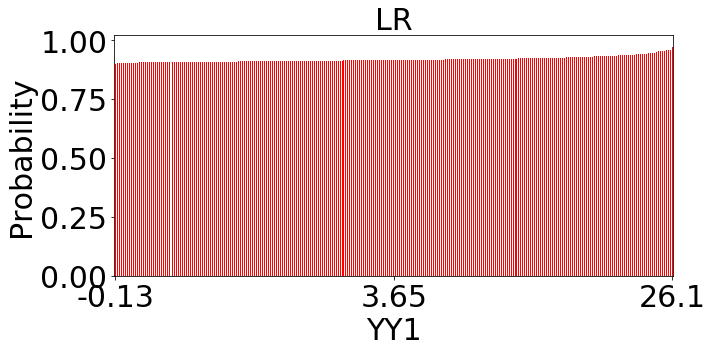

In [24]:
# Get the distribution
distribution = get_distribution(clf, X, y, 'YY1', 1)

# Plot the distribution
plot_distribution(distribution, 'YY1', 1)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/lg-alternative_splicing-1-YY1.png', dpi=300)
plt.show()

# 20 newsgroups' distributions

# Load data

In [25]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

#Get the three classes
categories = ['talk.politics.guns', 'rec.sport.baseball','comp.graphics']

# Load 20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train',categories=categories)

# Select tfidf feature
vectorizer = TfidfVectorizer() 
vectors = vectorizer.fit_transform(newsgroups_train.data)

#Get array
a = vectors.toarray()
b = newsgroups_train.target
c = newsgroups_train.target_names

#Transform target
b=[str(x) for x in b]
for i in range(0,1727):
    if b[i] == '0':
        b[i] = 'comp.graphics'
    if b[i] == '1':
        b[i] = 'rec.sport.baseball'
    if b[i] == '2':
        b[i] = 'talk.politics.guns'
        
#Get dataframe
b = np.array(b)
a = np.c_[b,a]
df = pd.DataFrame(a)

#Specify the name of the features
list_=['class']
for i in range(0,30664):
    str(i)
    list_.append('w'+str(i))
    
df.columns = list_
features = list_[1:]

# Get the features
X = df[features].values
# Get the target
y = df['class'].values

# Data preprocessing

In [26]:
# Standardize the features
X = scaler.fit_transform(X)

# Encode the target
y = le.fit_transform(y)

/home/user/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/user/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Hyperparameter tuning

In [27]:
tuning(X,y)

/home/user/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'clf__multi_class': 'ovr', 'clf__solver': 'lbfgs', 'clf__C': 10000} Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])


# Fit X and y

In [28]:
from sklearn.linear_model import LogisticRegression

# Declare the classifier
clf = LogisticRegression(multi_class='ovr', solver='lbfgs', C=10000, random_state=0)

# Train the classifier
clf.fit(X, y)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

# Plot distributions

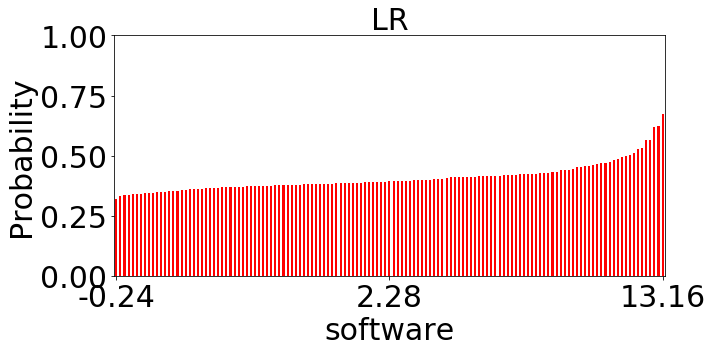

In [29]:
# Get the distribution
distribution = get_distribution(clf, X, y, "w25698", "comp.graphics")#software

# Plot the distribution
plot_distribution(distribution, "w25698", "comp.graphics")
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/lg-20news-comp-software.png', dpi=300)
plt.show()

# Spambase' distribution

# Load data

In [30]:
import pandas as pd

# Load the data
df = pd.read_csv('spambase.data', header=None)

# Specify the name of the columns
df.columns = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total', 'class']

# Features
features = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']

#Specify the name of the features
# Get the features
X = df[features].values
# Get the target
y = df['class'].values

# Data preprocessing

In [31]:
# Standardize the features
X = scaler.fit_transform(X)

# Hyperparameter tuning

In [32]:
tuning(X,y)

{'clf__multi_class': 'multinomial', 'clf__solver': 'newton-cg', 'clf__C': 10} Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])


# Fit X and y

In [33]:
from sklearn.linear_model import LogisticRegression

# Declare the classifier
clf = LogisticRegression(multi_class='multinomial', solver='newton-cg', C=10, random_state=0)

# Train the classifier
clf.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

# Plot distributions

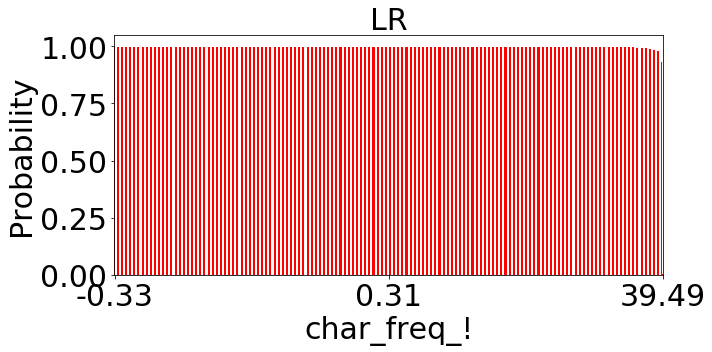

In [34]:
# Get the distribution
distribution = get_distribution(clf, X, y, 'char_freq_!', 0)

# Plot the distribution
plot_distribution(distribution, 'char_freq_!', 0)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/lg-spambase-0-char_freq_!.png', dpi=300)
plt.show()

# MNIST's distribution

# Load data

In [35]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('train.csv', header=None)

# Specify the name of the columns
list_=['class']
for i in range(0,784):
    str(i)
    list_.append('w'+str(i))
    
df.columns = list_
features = list_[1:]

# Get the features
X = df[features].values
# Get the target
y = df['class'].values

#Initialize a column
a=np.zeros([X.shape[0],1])

#Calculate the average of row
for i in range(0,28):
    b=np.mean(X[:,i*28:(i+1)*28],axis=1)
    a=np.c_[a,b]
    
#Calculate the average of column
n=0
for i in range(0,28):
    c=X[:,i]
    for j in range(28,784):
        if j%28==n:
            c=np.c_[c,X[:,j]]
    c=np.mean(c,axis=1)
    a=np.c_[a,c]
    n=n+1
    
#update X matrix    
X=a[:,1:58]

# Data preprocessing

In [36]:
# Standardize the features
X = scaler.fit_transform(X)

# Hyperparameter tuning

In [37]:
tuning(X,y)

{'clf__multi_class': 'multinomial', 'clf__solver': 'newton-cg', 'clf__C': 10} Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])


# Fit X and y

In [38]:
from sklearn.linear_model import LogisticRegression

# Declare the classifier
clf = LogisticRegression(multi_class='multinomial', solver='newton-cg', C=10, random_state=0)

# Train the classifier
clf.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

# Plot distributions

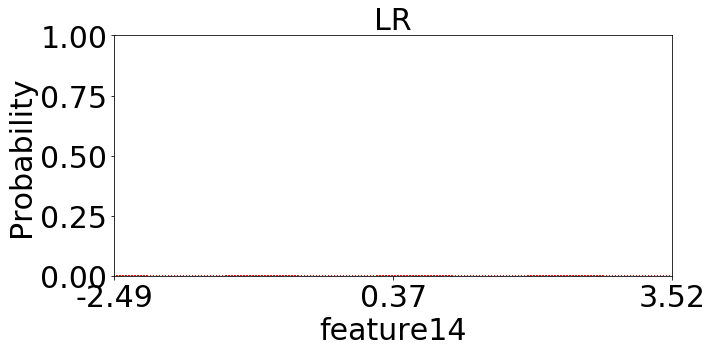

In [39]:
# Get the distribution
distribution = get_distribution(clf, X, y, "w41", 1)

# Plot the distribution
plot_distribution(distribution, "w41", 1)
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/lg-minist-1-column14.png', dpi=300)
plt.show()

# CIFAR-10's distribution

# Load data

In [5]:
import numpy as np
import random
import pandas as pd
import pickle
import platform
import os
 
#加载序列文件
def load_pickle(f):
    version=platform.python_version_tuple()#判断python的版本
    if version[0]== '2':
        return pickle.load(f)
    elif version[0]== '3':
        return pickle.load(f,encoding='latin1')
    raise ValueError("invalid python version:{}".format(version))

#处理原数据
def load_CIFAR_batch(filename):
    with open(filename,'rb') as f:
        datadict=load_pickle(f)
        X=datadict['data']
        Y=datadict['labels']
        #X=X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("float")
        #reshape()是在不改变矩阵的数值的前提下修改矩阵的形状,transpose()对矩阵进行转置
        Y=np.array(Y)
        return X,Y
        
        
#返回可以直接使用的数据集
def load_CIFAR10(ROOT):
    xs=[]
    ys=[]
    for b in range(1,6):
        f=os.path.join(ROOT,'data_batch_%d'%(b,))#os.path.join()将多个路径组合后返回
        X,Y=load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr=np.concatenate(xs)#这个函数用于将多个数组进行连接
    Ytr=np.concatenate(ys)
    del X,Y
    Xte,Yte=load_CIFAR_batch(os.path.join(ROOT,'test_batch'))
    return Xtr,Ytr,Xte,Yte

datasets='cifar-10-batches-py'
X_train,Y_train,X_test,Y_test=load_CIFAR10(datasets)

#get R,G,B array
XR = X_train[:,:1024]
XG = X_train[:,1024:2048]
XB = X_train[:,2048:3072]

XR = np.c_[Y_train, XR]
XG = np.c_[Y_train, XG]
XB = np.c_[Y_train, XB]

#get dataframe
df = pd.DataFrame(XR)

#name each pixel point
list_=['class']
for i in range(0,32):#row
    for j in range(0,32):#column
        list_.append(str(i)+'-'+str(j)+'R')
    
df.columns = list_
#Specify the name of the features
#del list_[0]
features = list_[1:]
# Get the features
X = df[features].values
# Get the target
y = df['class'].values

# Data preprocessing

In [6]:
# Standardize the features
X = scaler.fit_transform(X)

/home/user/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/user/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Hyperparameter tuning

In [7]:
tuning(X,y)

{'clf__multi_class': 'ovr', 'clf__C': 0.001, 'clf__solver': 'newton-cg'} Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])


# Fit X and y

In [8]:
from sklearn.linear_model import LogisticRegression

# Declare the classifier
clf = LogisticRegression(multi_class='ovr', solver='newton-cg', C=0.001, random_state=0)

# Train the classifier
clf.fit(X, y)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

# Plot distributions

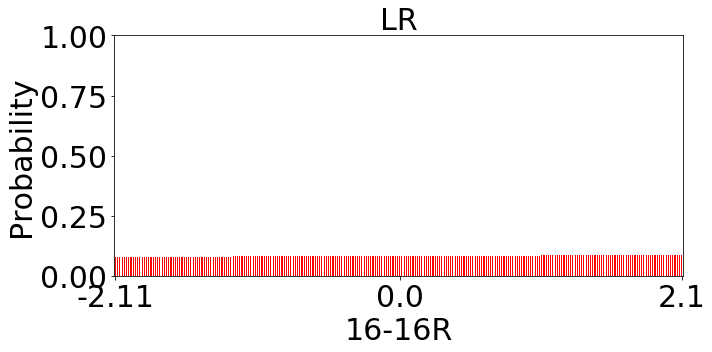

In [9]:
distribution = get_distribution(clf, X, y, "16-16R", 1)

# Plot the distribution
plot_distribution(distribution, "16-16R", 1)
#save the figure
plt.savefig('/media/user/2FD84FB396A78049/lwqa/pics/lg-cifar-10-1-16-16R.png', dpi=300)
plt.show()